In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import tools._torch_tools as tt
import models.loss as lo
from models.interpolation import Model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)

data_folder = "dataset_interpolation/"

Device is cpu


In [2]:
X_train, y_train = mt.loadData(data_folder,train=True,typeF='float16',channels_last=False)

Loading dataset_interpolation/X_train.npy
Loading dataset_interpolation/y_train.npy
Loading dataset_interpolation/X_val.npy
Loading dataset_interpolation/y_val.npy


In [2]:
X_val, y_val =  mt.loadData(data_folder,val=True,typeF='float16',channels_last=False)

Loading dataset_interpolation/X_val.npy
Loading dataset_interpolation/y_val.npy


In [2]:
X_test, y_test = tt.loadData(data_folder,test=True,typeF='float16',channels_last=False)

Loading ../../datasets/dataset_interpolation_96/X_test.npy
Loading ../../datasets/dataset_interpolation_96/y_test.npy


### Training with the L1 loss

In [3]:
model = Model()
training = tt.Training(model, device, X_train, y_train, X_val, y_val, loss_function=nn.L1Loss())

In [4]:
try:
    training.fit(32,50,val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")



====== TRAINING ======
===> Epoch[1]

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


===> Epoch[1](5/1387): Loss: 0.0637	ETA 1:39:23	Epoch Loss: 0.0776

Finished training.


In [6]:
training.save("l1.pth")

In [8]:
tt.plotHistory(training.history,save="history.png",size=(5,4))
tt.toCSV("history.csv",training.history)

NameError: name 'plt' is not defined

### Training with the perceptual loss

In [3]:
model = Model()
model.load_state_dict(torch.load("l1.pth",map_location=device))
loss = lo.CombinedLoss(-18,0.00001)
training = tt.Training(model, device, X_train, y_train, X_val, y_val, loss_function=loss)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/mato/.torch/models/vgg19-dcbb9e9d.pth
336052224.0 bytes

In [ ]:
try:
    training.fit(32,35,val=True)
except KeyboardInterrupt:
    print("\n\nFinished training.")

In [ ]:
training.save("final.pth")

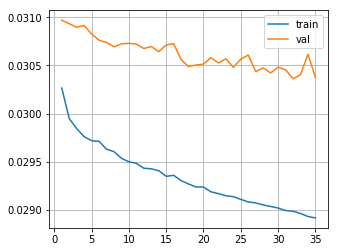

In [22]:
tt.plotHistory(training.history,size=(5,4),save="history_2.png")
tt.toCSV("history_2.csv",training.history)

### SSIM index on test dataset

In [ ]:
def validateSSIM(in_weights, X_set, y_set):
    model = Model()
    model.load_state_dict(torch.load(in_weights,map_location=device))
    model.eval()
    validating = tt.Training(model,device,X_set, y_set, X_set, y_set, loss_function=lo.SSIMLoss())
   
    return validating.validate(1)

In [ ]:
final_test_SSIM = validateSSIM("final.pth",X_test, y_test)